# Visualization for Overview

## Attributes to Measure Efficiency of the Visualization

Let's use Radar Chart with 4~6 axis

4~6 attributes 
1. time
2. total number of fixations
3. avg fix duration
4. scan path
5. area of convex hull
6. avg pupil dilation
7. total number of clicks

*all in average(mean) for the group of participants*


### Data needed for each participant

- [x] time
  - time on task
    - from `Others/participant_data.js`

- [x] total # of fixations
  - last fixation's serial number
- [x] avg fix duration
  - calculate average durations
    - fixation data from `Raw_Data/p1/p1.treeFXD.txt, Raw_Data/p1/p1.graphFXD.txt, Raw_Data/p2/p2.treeFXD.txt, Raw_Data/p2/p2.graphFXD.txt, ...`
  
- [x] scan path
  - calculate saccadic length between each fixations
  - add all saccadic length up
- [x] avg saccadic length
  - get avg of all saccadic length
      - fixation data from `Raw_Data/... p1/p1.treeFXD.txt, p1/p1.graphFXD.txt, p2/p2.treeFXD.txt, p2/p2.graphFXD.txt, ...`

- [x] avg pupil dilation
  - [x] avg baseline (b/c of different base pupil sizes depend on ppl's eyes and conditions)
    - baseline data from `Raw_Data/p1/p1GZD.txt, Raw_Data/p2/p2GZD.txt, ...`
  - [x] avg left, right pupil size throughout the task
    - gaze data from `filtered_data/... p1/p1treeGZD.js, p1/p1graphGZD.js, p2/p1treeGZD.js, ...`
  
- [x] area of convex hull
  - calculate it using [scipy.spatial.ConvexHull](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html)
    - fixation from `Raw_Data/... p1/p1.treeFXD.txt, p1/p1.graphFXD.txt, p2/p2.treeFXD.txt, p2/p2.graphFXD.txt, ...`
  
- [x] total # of clicks
  - count the total 'LMouseButton' events
    - event data from `Raw_Data/... p1/p1.treeEVD.txt, p1/p1.graphEVD.txt, p2/p2.treeEVD.txt, p2/p2.graphEVD.txt, ...`
    

### Final output planned
for example...
1. overview_participant.csv
```
pid,ont_type,vis_type,session_type,time,success,totalfix,avg_fix_duration,scanpath,avg_saccadic_length,avg_pupil_dilation,convexhull_area,totalclick
p1,1,1,1,26,0.608695652,2647,140,10000,20,1.2,1000,606
p1,2,2,4,38,0.52173913,2422,200,20000,10,2.0,1200,984
p2,1,2,3,19,0.347826087,2581,,,,,,416
p2,2,1,2,25,0.391304348,1166,,,,,,371
p3,1,1,1,10,0.47826087,1564,,,,,,173
p3,2,2,4,50,0.391304348,7967,,,,,,891
p4,1,2,3,12,0.391304348,590,,,,,,235
p4,2,1,2,9,0.52173913,605,,,,,,254
```
2. overview_combined.csv
```
sessionID,ont_type,vis_type,m_time,m_success,m_totalfix,m_avg_fix_duration,m_scanpath,m_avg_saccadic_length,m_avg_pupil_dilation,m_convexhull_area,m_totalclick
1,general,tree,18,0.5,2000,,,,,,490
2,expert,tree,17,0.45,850,,,,,,310
3,general,graph,15.5,0.37,1500,,,,,,300
4,expert,graph,44,0.45,5000,,,,,,930
```

#### Field info

ontology type:
1. general
2. expert

visualization type:
1. tree
2. graph

session type:
1. general - tree
3. expert - tree
2. general - graph
4. expert - graph


## Import libraries

In [1]:
#importing necessary libraries
import pandas as pd
import os
import glob
from math import sqrt
from statistics import mean
from scipy.spatial import ConvexHull

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import warnings
warnings.filterwarnings("ignore")


In [210]:
# path to read data from
dirPath = '../Raw_Data/'

## Loading the data

## 1. ont_type, vis_type, time, success

In [211]:
participants_df = pd.read_csv(dirPath+'Additional Participant Data.csv', usecols=range(5))
participants_df.rename(columns = {'ID':'pid', 
                     'Ontologies': 'ont_type', 
                     'Visualization': 'vis_type',
                     'Task_Success': 'success',
                     'Time_On_Task': 'time'}, inplace = True)

# for the order of the columns
participants_df = participants_df[['pid','ont_type','vis_type','success','time']]

# round float data
participants_df = participants_df.round(2)

participants_df.head(5)

,pid,ont_type,vis_type,success,time
0,p1,1,1,0.61,26
1,p1,2,2,0.52,38
2,p3,1,1,0.48,10
3,p3,2,2,0.39,50
4,p5,1,1,0.52,22


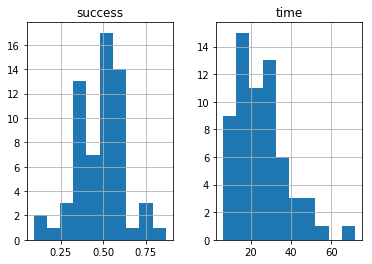

In [212]:
participants_df[['time','success']].hist();

## 2. totalfix, avg_fixation_duration

## 2-1. Work with multiple fixation files
Combine all???

In [4]:
FXD_filenames = [i for i in glob.glob(dirPath+'p*/p*.*FXD.txt')]

In [5]:
fix_dfs = pd.concat([pd.read_csv(f, sep="\t", header=None) for f in FXD_filenames])
fix_dfs.rename(columns = {0:'number', 
                     1: 'timestamp', 
                     2: 'duration', 
                     3: 'x', 
                     4: 'y'}, inplace = True)
fix_dfs.head()


,number,timestamp,duration,x,y
0,1,475,100,632,405
1,2,4084,100,285,197
2,3,4622,339,72,208
3,4,7792,199,304,978
4,5,8490,120,389,915


In [6]:
print ('total data count :', len(fix_dfs.index))

total data count : 193536


But, I don't want to use this smashed one.  
The attributes I want to use should be calculated for each fixation file.  
Then...

## 2-2. Let's test the process with one fixation file first

## Process Data: 1 Fixation

In [7]:
# Function to pre-process fixation data dataframe
def prepFXD(fxdf):
    fxdf.rename(columns = {0:'number', 
                     1: 'timestamp', 
                     2: 'duration', 
                     3: 'x', 
                     4: 'y'}, inplace = True)
    return fxdf

# testing with one fixation file
p1_treeFXD_df = pd.read_csv(dirPath+"p1/p1.treeFXD.txt", sep = "\t", header=None, usecols=range(5))
p1_treeFXD_df = prepFXD(p1_treeFXD_df)
p1_treeFXD_df.head()

# p1_treeFXD_df.set_index('number', inplace = True)  # set 'number'column as a key
# p1_treeFXD_df[['duration']].head()  # can get dataframe only with the selected column

,number,timestamp,duration,x,y
0,1,2027,100,1005,60
1,2,7968,319,78,237
2,3,8526,100,246,207
3,4,9105,140,298,198
4,5,9962,140,909,1002


### Calculating Saccadic Length

In [8]:
p1_treeFXD_df['saccadic_length'] = 0  # can add a new column and assign value this way
p1_treeFXD_df.head()

,number,timestamp,duration,x,y,saccadic_length
0,1,2027,100,1005,60,0
1,2,7968,319,78,237,0
2,3,8526,100,246,207,0
3,4,9105,140,298,198,0
4,5,9962,140,909,1002,0


In [9]:
# function to calculate distance between two points
def calculateDistance(x1,y1,x2,y2):
     d = sqrt((x2 - x1)**2 + (y2 - y1)**2)
     return d

In [10]:
# Function to return array of distances from array of points
def getDistances(points):
    distances = []
    for i in range(len(points['x'])):
        if i == 0:
            distances.append(None)
            continue
        x1 = points.loc[i-1,'x']
        y1 = points.loc[i-1,'y']
        x2 = points.loc[i,'x']
        y2 = points.loc[i,'y']
        distances.append(calculateDistance(x1,y1,x2,y2))
    return distances

saccadicLengths = getDistances(p1_treeFXD_df)
saccadicLengths[:5]

[None,
 943.7467880740045,
 170.6575518399347,
 52.773099207835045,
 1009.8202810401463]

### Average Saccadic Length

In [25]:
# Function to get average saccadic length from fixation datafram
def getAvgSaccadicLength(fixdf):
    saccadicLengths = getDistances(fixdf)
    return mean( filter(None, saccadicLengths) )

AvgSaccadicLength = getAvgSaccadicLength(p1_treeFXD_df)
print ("AvgSaccadicLength:", round(AvgSaccadicLength,2))

AvgSaccadicLength: 160.96


### Scan Path

In [26]:
# Function to get scanpath from fixation dataframe
def getScanpath(fixdf):
    saccadicLengths = getDistances(fixdf)
    return sum( filter(None, saccadicLengths) )

Scanpath = getScanpath(p1_treeFXD_df)
print ("Scanpath:", round(Scanpath,2))

Scanpath: 425894.36


### Area of Convex Hull

In [28]:
# Function to get area of convex hull from fixation dataframe
def getConvexHullArea(fixdf):
    points = fixdf[['x','y']]
    hull = ConvexHull(points)
    # since the fixation data is 2d, area is hull.area, not hull.volume
    return hull.area

ConvexHullArea = getConvexHullArea(p1_treeFXD_df)
print ("Area of ConvexHull:", ConvexHullArea)

Area of ConvexHull: 3724.835369425075


### Total Fixations

In [52]:
def getTotalFix(fixdf):
    return len(fixdf.index)

TotalFix = getTotalFix(p1_treeFXD_df)
print ("TotalFix :", TotalFix)

TotalFix : 2647


### Average Fixation Duration

In [15]:
def getAvgDuration(fixdf):
    return round( mean( filter(None, fixdf['duration']) ) )

AvgDuration = getAvgDuration(p1_treeFXD_df)
print ("AvgDuration :", AvgDuration)

AvgDuration : 152


## Process Data: 2 Gaze

In [42]:
# Function to pre-process gaze data dataframe
def prepGZD(gzdf):
    gzdf.rename(columns ={0:'timestamp', 
                     1: 'number', 
                     2: 'screen_x_left', 
                     3: 'screen_y_left', 
                     4: 'cam_x_left',
                     5:'cam_y_left',
                     6:'distance_left',
                     7:'pupil_left',
                     8:'code_left', 
                    9:'screen_x_right', 
                    10:'screen_y_right',
                    11:'cam_x_rigth',
                    12:'cam_y_right',
                    13:'distance_right', 
                    14:'pupil_right', 
                    15:'code_right'}, inplace = True)
    # clean invalid data (only keep valid ones) based on validity code
#     print ('raw data count:', len(gzdf.index))
    gzdf = gzdf.loc[((gzdf['code_left'] == 0) & (gzdf['code_right'] == 0))]
#     print ('after cleaning invalid:', len(gzdf.index))
    
    # clean negative pupil size (only keep positive pupil size)
    gzdf = gzdf.loc[((gzdf['pupil_left'] > 0) & (gzdf['pupil_right'] > 0))]
#     print ('after cleaning negative:', len(gzdf.index))
    
    # drop validity code columns
    
    # add new column for average left&right pupil size
    gzdf['pupil_avg'] = gzdf[['pupil_left','pupil_right']].mean(axis=1)
    
    # drop unnecessary columns (only keep useful columns)
    gzdf = gzdf[['number','timestamp','pupil_avg']]

    return gzdf


In [30]:
# process pupil size data
p1_treeGZD_df = pd.read_csv(dirPath+"p1/p1.treeGZD.txt", sep = "\t", header=None, usecols=range(16))
# p1_treeGZD_df.head()

p1_treeGZD_df = prepGZD(p1_treeGZD_df)
# p1_treeGZD_df.head()
p1_treeGZD_df.describe()

raw data count: 77057
after cleaning invalid: 68422
after cleaning negative: 68415


,number,timestamp,pupil_avg
count,68415.000000,6.841500e+04,68415.000000
mean,38198.545904,7.615756e+05,3.508406
std,21920.857519,4.370466e+05,0.125032
min,8.000000,1.530000e+02,2.828000
25%,19498.500000,3.887440e+05,3.431000
50%,38028.000000,7.581750e+05,3.504500
75%,57281.500000,1.142042e+06,3.580000
max,77057.000000,1.536315e+06,5.897500


### Average Pupil Size
Get average left&right pupil sizes from gaze data `p*/p**GZD.txt`

In [18]:
# Function to get average pupil size from gaze data
def getAvgPupil(gzdf):
    return mean(gzdf['pupil_avg'])

In [19]:
AvgPupil = getAvgPupil(p1_treeGZD_df)
print ("Average pupil size: ", AvgPupil)

Average pupil size:  3.508406073229555


### Baseline
Get average pupil sizes from baseline gaze data `p*/p*GZD.txt`

In [20]:
# process baseline data
p1_baseGZD_df = pd.read_csv(dirPath+"p1/p1GZD.txt", sep = "\t", header=None)
p1_baseGZD_df = prepGZD(p1_baseGZD_df)
p1_baseGZD_df.describe()


raw data count: 515
after cleaning invalid: 372
after cleaning negative: 370


,number,timestamp,pupil_avg
count,370.000000,370.000000,370.000000
mean,273.289189,5434.627027,3.573054
std,146.509377,2921.026517,0.143388
min,9.000000,165.000000,3.018500
25%,146.250000,2902.000000,3.512000
50%,278.000000,5528.500000,3.572750
75%,403.500000,8031.000000,3.655500
max,515.000000,10254.000000,3.889500


In [21]:
Baseline = getAvgPupil(p1_baseGZD_df)
print ("Baseline pupil size: ", Baseline)

Baseline pupil size:  3.573054054054054


### Pupil Dilation
= Average pupil size - Baseline 

In [22]:
PupilDilation = AvgPupil - Baseline
print ("PupilDilation: ", PupilDilation)

PupilDilation:  -0.0646479808244993


## Process Data: 3 Event

In [23]:
# Function to pre-process event data dataframe
def prepEVD(evdf):
    evdf.rename(columns = {0:'time', 
                     1: 'event', 
                     2: 'event_key', 
                     3: 'data1', 
                     4: 'data2',
                     5:'description'}, inplace = True)
    return evdf

#process event data
p1_treeEVD_df = pd.read_csv(dirPath+"p1/p1.treeEVD.txt", sep = "\t", header=None, usecols=range(6))
p1_treeEVD_df = prepEVD(p1_treeEVD_df)
p1_treeEVD_df.head()

,time,event,event_key,data1,data2,description
0,1887,LMouseButton,1,1025,16,NaN
1,10299,LMouseButton,1,857,1007,NaN
2,12252,LMouseButton,1,1049,1011,NaN
3,38096,LMouseButton,1,45,549,NaN
4,41116,LMouseButton,1,685,527,NaN


### Total Clicks
Count 'LMouseButton' event from event data `p*/p**EVD.txt`

In [24]:
# Function to count mouse click event (LMouseButton)
def getTotalClick(evdf):
    count = len(evdf.loc[(evdf['event'] == 'LMouseButton')])
    return count

TotalClick = getTotalClick(p1_treeEVD_df)
print ("TotalClick: ", TotalClick)

TotalClick:  606


# Summing up for one participant
## Reading all data needed

In [113]:
# Function to read data files(FXD,GZD,EVD,baseGZD) for one participant
# returns FXD, GZD, baseGZD, EVD dataframe
def readData(pid, vistype):
    print("Read data for",pid, vistype)
    # fixation data
    # path is like "../Raw_Data/p1/p1.treeFXD.txt"
    path = dirPath + pid + "/" + pid + "." + vistype + "FXD.txt"
    fxdf = pd.read_csv(path, sep = "\t", header=None, usecols=range(5))
    fxdf = prepFXD(fxdf)
    print ("  - FXD '"+path+"'", "\t count:", len(fxdf.index))
    
    # gaze data
    path = dirPath + pid + "/" + pid + "." + vistype + "GZD.txt"
    gzdf = pd.read_csv(path, sep = "\t", header=None, usecols=range(16))
    gzdf = prepGZD(gzdf)
    print ("  - GZD '"+path+"'", "\t count:", len(gzdf.index))
    
    # event data
    path = dirPath + pid + "/" + pid + "." + vistype + "EVD.txt"
    evdf = pd.read_csv(path, sep = "\t", header=None, usecols=range(6))
    evdf = prepEVD(evdf)
    print ("  - EVD '"+path+"'", "\t count:", len(evdf.index))
    
    # baseline gaze data
    path = dirPath + pid + "/" + pid + "GZD.txt"
    basegzdf = pd.read_csv(path, sep = "\t", header=None, usecols=range(16))
    basegzdf = prepGZD(basegzdf)
    print ("  - baseGZD '"+path+"'", " \t count:", len(basegzdf.index))
    
    return fxdf, gzdf, evdf, basegzdf

p1_tree_fxdf, p1_tree_gzdf, p1_tree_evdf, p1_tree_basegzdf = readData("p1","tree")

Read data for p1 tree
  - FXD '../Raw_Data/p1/p1.treeFXD.txt' 	 count: 2647
  - GZD '../Raw_Data/p1/p1.treeGZD.txt' 	 count: 68415
  - EVD '../Raw_Data/p1/p1.treeEVD.txt' 	 count: 813
  - baseGZD '../Raw_Data/p1/p1GZD.txt'  	 count: 370


## Fetching all attributes needed

In [150]:
col_names =  ['pid','vis_type',
              'totalfix','avg_fix_duration',
              'scanpath','avg_saccadic_length',
              'pupil_baseline','avg_pupil','avg_pupil_dilation',
              'convexhull_area',
              'totalclick']

In [230]:
def getOverviewData(pid, vistype):    
    fxdf, gzdf, evdf, basegzdf = readData(pid,vistype)
    
    basePupil = getAvgPupil(basegzdf)
    avgPupil = getAvgPupil(gzdf)
    avgDilation = avgPupil - basePupil
    my_dic = {'pid': pid,
              'vis_type': vistype,
              'totalfix': getTotalFix(fxdf),
              'avg_fix_duration': round(getAvgDuration(fxdf), 4),
              'scanpath': getScanpath(fxdf),
              'avg_saccadic_length': round(getAvgSaccadicLength(fxdf), 4),
              'pupil_baseline': round(basePupil, 4),
              'avg_pupil': round(avgPupil, 4),
              'avg_pupil_dilation': round(avgDilation, 4),
              'convexhull_area': round(getConvexHullArea(fxdf), 2),
              'totalclick': getTotalClick(evdf)
             }
    
    my_df  = pd.DataFrame(index = [0], columns = col_names)
    my_df.loc[0] = my_dic
    
    return my_df


p1tree = getOverviewData("p1","tree")
p1tree

Read data for p1 tree
  - FXD '../Raw_Data/p1/p1.treeFXD.txt' 	 count: 2647
  - GZD '../Raw_Data/p1/p1.treeGZD.txt' 	 count: 68415
  - EVD '../Raw_Data/p1/p1.treeEVD.txt' 	 count: 813
  - baseGZD '../Raw_Data/p1/p1GZD.txt'  	 count: 370


,pid,vis_type,totalfix,avg_fix_duration,scanpath,avg_saccadic_length,pupil_baseline,avg_pupil,avg_pupil_dilation,convexhull_area,totalclick
0,p1,tree,2647,152,425894,160.958,3.5731,3.5084,-0.0646,3724.84,606


# Working with groups of participants

Now, need to get overview of one participant.  
And make it work for groups of participants.

In [231]:
# replace vis_type values to match
participants_df = participants_df.replace({"vis_type":1},"tree")
participants_df = participants_df.replace({"vis_type":2},"graph")
participants_df = participants_df.replace({"ont_type":1},"general")
participants_df = participants_df.replace({"ont_type":2},"expert")

# round success rate
# participants_df['success'].round(2)

participants_df.head()

,pid,ont_type,vis_type,success,time
0,p1,general,tree,0.61,26
1,p1,expert,graph,0.52,38
2,p3,general,tree,0.48,10
3,p3,expert,graph,0.39,50
4,p5,general,tree,0.52,22


In [232]:
# space to store newly generated overview of each participant
overview_df = pd.DataFrame(columns = col_names)
overview_df

,pid,vis_type,totalfix,avg_fix_duration,scanpath,avg_saccadic_length,pupil_baseline,avg_pupil,avg_pupil_dilation,convexhull_area,totalclick


In [233]:
# Go through the pid and vis_type, and fetch data for each participants
for i, row in participants_df.iterrows():
# for i, row in participants_df.loc[:2].iterrows():
    print ('\n' + row['pid'], row['vis_type'])
    newdf = getOverviewData(row['pid'], row['vis_type'])
    overview_df = overview_df.append(newdf, ignore_index = True)



p1 tree
Read data for p1 tree
  - FXD '../Raw_Data/p1/p1.treeFXD.txt' 	 count: 2647
  - GZD '../Raw_Data/p1/p1.treeGZD.txt' 	 count: 68415
  - EVD '../Raw_Data/p1/p1.treeEVD.txt' 	 count: 813
  - baseGZD '../Raw_Data/p1/p1GZD.txt'  	 count: 370

p1 graph
Read data for p1 graph
  - FXD '../Raw_Data/p1/p1.graphFXD.txt' 	 count: 2422
  - GZD '../Raw_Data/p1/p1.graphGZD.txt' 	 count: 88628
  - EVD '../Raw_Data/p1/p1.graphEVD.txt' 	 count: 1207
  - baseGZD '../Raw_Data/p1/p1GZD.txt'  	 count: 370

p3 tree
Read data for p3 tree
  - FXD '../Raw_Data/p3/p3.treeFXD.txt' 	 count: 1564
  - GZD '../Raw_Data/p3/p3.treeGZD.txt' 	 count: 30000
  - EVD '../Raw_Data/p3/p3.treeEVD.txt' 	 count: 277
  - baseGZD '../Raw_Data/p3/p3GZD.txt'  	 count: 486

p3 graph
Read data for p3 graph
  - FXD '../Raw_Data/p3/p3.graphFXD.txt' 	 count: 7967
  - GZD '../Raw_Data/p3/p3.graphGZD.txt' 	 count: 145095
  - EVD '../Raw_Data/p3/p3.graphEVD.txt' 	 count: 1061
  - baseGZD '../Raw_Data/p3/p3GZD.txt'  	 count: 486

p5


p2 graph
Read data for p2 graph
  - FXD '../Raw_Data/p2/p2.graphFXD.txt' 	 count: 1166
  - GZD '../Raw_Data/p2/p2.graphGZD.txt' 	 count: 40772
  - EVD '../Raw_Data/p2/p2.graphEVD.txt' 	 count: 371
  - baseGZD '../Raw_Data/p2/p2GZD.txt'  	 count: 331

p2 tree
Read data for p2 tree
  - FXD '../Raw_Data/p2/p2.treeFXD.txt' 	 count: 2581
  - GZD '../Raw_Data/p2/p2.treeGZD.txt' 	 count: 69725
  - EVD '../Raw_Data/p2/p2.treeEVD.txt' 	 count: 416
  - baseGZD '../Raw_Data/p2/p2GZD.txt'  	 count: 331

p4 graph
Read data for p4 graph
  - FXD '../Raw_Data/p4/p4.graphFXD.txt' 	 count: 605
  - GZD '../Raw_Data/p4/p4.graphGZD.txt' 	 count: 30581
  - EVD '../Raw_Data/p4/p4.graphEVD.txt' 	 count: 357
  - baseGZD '../Raw_Data/p4/p4GZD.txt'  	 count: 373

p4 tree
Read data for p4 tree
  - FXD '../Raw_Data/p4/p4.treeFXD.txt' 	 count: 590
  - GZD '../Raw_Data/p4/p4.treeGZD.txt' 	 count: 22990
  - EVD '../Raw_Data/p4/p4.treeEVD.txt' 	 count: 242
  - baseGZD '../Raw_Data/p4/p4GZD.txt'  	 count: 373

p6 grap

In [234]:
overview_df

,pid,vis_type,totalfix,avg_fix_duration,scanpath,avg_saccadic_length,pupil_baseline,avg_pupil,avg_pupil_dilation,convexhull_area,totalclick
0,p1,tree,2647,152,425894,160.958,3.5731,3.5084,-0.0646,3724.84,606
1,p1,graph,2422,148,334228,138.054,3.5731,3.4638,-0.1093,3680.45,984
2,p3,tree,1564,330,211030,135.016,3.0114,3.1883,0.1768,4141.72,173
3,p3,graph,7967,309,976608,122.674,3.0114,3.1404,0.129,4227.36,891
4,p5,tree,2445,204,308060,126.047,3.3014,3.3529,0.0514,3757.05,314
5,p5,graph,1604,171,210346,131.302,3.3014,3.2999,-0.0015,3628.37,601
6,p7,tree,2711,248,329796,121.741,3.651,3.6049,-0.0461,3693.18,364
7,p7,graph,2467,227,263108,106.694,3.651,3.6241,-0.027,4605.28,377
8,p11,tree,1152,143,186921,162.399,3.9187,3.7209,-0.1978,3633.73,304
9,p11,graph,3657,158,518608,141.89,3.9187,3.7837,-0.135,4088.2,830


## Merge the dataset

In [235]:
result = pd.merge(participants_df, overview_df, on=['pid','vis_type'], how='outer')
result

,pid,ont_type,vis_type,success,time,totalfix,avg_fix_duration,scanpath,avg_saccadic_length,pupil_baseline,avg_pupil,avg_pupil_dilation,convexhull_area,totalclick
0,p1,general,tree,0.61,26,2647,152,425894,160.958,3.5731,3.5084,-0.0646,3724.84,606
1,p1,expert,graph,0.52,38,2422,148,334228,138.054,3.5731,3.4638,-0.1093,3680.45,984
2,p3,general,tree,0.48,10,1564,330,211030,135.016,3.0114,3.1883,0.1768,4141.72,173
3,p3,expert,graph,0.39,50,7967,309,976608,122.674,3.0114,3.1404,0.129,4227.36,891
4,p5,general,tree,0.52,22,2445,204,308060,126.047,3.3014,3.3529,0.0514,3757.05,314
5,p5,expert,graph,0.43,27,1604,171,210346,131.302,3.3014,3.2999,-0.0015,3628.37,601
6,p7,general,tree,0.57,16,2711,248,329796,121.741,3.651,3.6049,-0.0461,3693.18,364
7,p7,expert,graph,0.09,20,2467,227,263108,106.694,3.651,3.6241,-0.027,4605.28,377
8,p11,general,tree,0.48,15,1152,143,186921,162.399,3.9187,3.7209,-0.1978,3633.73,304
9,p11,expert,graph,0.35,33,3657,158,518608,141.89,3.9187,3.7837,-0.135,4088.2,830


In [236]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 14 columns):
pid                    62 non-null object
ont_type               62 non-null object
vis_type               62 non-null object
success                62 non-null float64
time                   62 non-null int64
totalfix               62 non-null object
avg_fix_duration       62 non-null object
scanpath               62 non-null object
avg_saccadic_length    62 non-null object
pupil_baseline         62 non-null object
avg_pupil              62 non-null object
avg_pupil_dilation     62 non-null object
convexhull_area        62 non-null object
totalclick             62 non-null object
dtypes: float64(1), int64(1), object(12)
memory usage: 7.3+ KB


?? Why the data types are all object?  
Better to have proper data type to experiment the data here.

In [237]:
# assign proper data types to the columns of result dataframe
dtype = {'pid': str,
         'ont_type': str,
         'vis_type': str,
         'time': int,
         'success': float,
         'totalfix': int,
         'avg_fix_duration': float,
         'scanpath': int,
         'avg_saccadic_length': float,
         'pupil_baseline': float,
         'avg_pupil': float,
         'avg_pupil_dilation': float,
         'convexhull_area': int,
         'totalclick': int
        }
result = result.astype(dtype)
result.dtypes

pid                     object
ont_type                object
vis_type                object
success                float64
time                     int64
totalfix                 int64
avg_fix_duration       float64
scanpath                 int64
avg_saccadic_length    float64
pupil_baseline         float64
avg_pupil              float64
avg_pupil_dilation     float64
convexhull_area          int64
totalclick               int64
dtype: object

In [238]:
result.describe()

,success,time,totalfix,avg_fix_duration,scanpath,avg_saccadic_length,pupil_baseline,avg_pupil,avg_pupil_dilation,convexhull_area,totalclick
count,62.000000,62.000000,62.000000,62.000000,6.200000e+01,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000
mean,0.478548,24.919355,3140.129032,229.774194,4.213343e+05,137.833481,3.607971,3.674639,0.066658,3944.822581,476.758065
std,0.141906,13.249557,2143.640618,66.368178,2.865760e+05,27.009323,0.461321,0.426632,0.206008,412.576094,286.234381
min,0.090000,6.000000,410.000000,137.000000,4.500900e+04,95.852600,2.394500,2.722000,-0.474800,2983.000000,130.000000
25%,0.390000,14.250000,1644.250000,176.750000,2.140265e+05,120.877500,3.296300,3.359500,-0.042550,3707.500000,254.000000
50%,0.480000,22.500000,2503.500000,215.500000,3.371075e+05,132.555400,3.592600,3.719050,0.076600,3949.000000,411.500000
75%,0.570000,31.500000,4131.250000,269.000000,5.434992e+05,147.413050,3.918775,3.892425,0.200275,4120.750000,604.750000
max,0.870000,72.000000,11294.000000,376.000000,1.492083e+06,227.653500,4.506900,4.855300,0.470100,5550.000000,1593.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1f2bf5f8>,
      dtype=object)

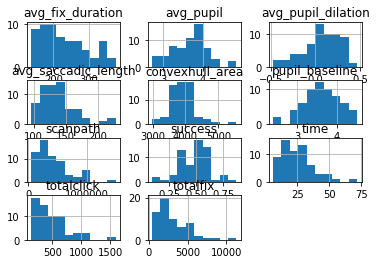

In [239]:
result.hist()

In [244]:
# write the result data to csv file
    
# result.to_csv('./overview.csv', index='Number')

,pid,ont_type,vis_type,success,time,totalfix,avg_fix_duration,scanpath,avg_saccadic_length,pupil_baseline,avg_pupil,avg_pupil_dilation,convexhull_area,totalclick
0,p1,general,tree,0.61,26,2647,152.0,425894,160.9578,3.5731,3.5084,-0.0646,3724,606
1,p1,expert,graph,0.52,38,2422,148.0,334228,138.0539,3.5731,3.4638,-0.1093,3680,984
2,p3,general,tree,0.48,10,1564,330.0,211030,135.0163,3.0114,3.1883,0.1768,4141,173
3,p3,expert,graph,0.39,50,7967,309.0,976608,122.6741,3.0114,3.1404,0.1290,4227,891
4,p5,general,tree,0.52,22,2445,204.0,308060,126.0475,3.3014,3.3529,0.0514,3757,314
5,p5,expert,graph,0.43,27,1604,171.0,210346,131.3022,3.3014,3.2999,-0.0015,3628,601
6,p7,general,tree,0.57,16,2711,248.0,329796,121.7409,3.6510,3.6049,-0.0461,3693,364
7,p7,expert,graph,0.09,20,2467,227.0,263107,106.6941,3.6510,3.6241,-0.0270,4605,377
8,p11,general,tree,0.48,15,1152,143.0,186921,162.3989,3.9187,3.7209,-0.1978,3633,304
9,p11,expert,graph,0.35,33,3657,158.0,518608,141.8901,3.9187,3.7837,-0.1350,4088,830


# Experiment the visualization for each session types